In [4]:
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew, moment, mode
import numpy as np

data = open("data.txt")

numbers = data.read().split()

for i in range(len(numbers)):
    num = numbers[i].split('e')
    numbers[i] = float(num[0])*10**int(num[1])
    
numbers = np.array(numbers)
numbers.sort()

In [5]:
print(f"Mean: {round(np.mean(numbers), 3)}")
# unbiased
print(f"Variance(unbiased): {round(np.var(numbers, ddof=1), 3)}")
print(f"Kurtosis(unbiased): {round(kurtosis(numbers, bias=False), 3)}")
print(f"Skew(unbiased): {round(skew(numbers, bias=False), 3)}")
# unbiased
# print(round(sum([(n-np.mean(numbers))**2 for n in numbers]) / (len(numbers) - 1), 3))

Mean: 3.867
Variance(unbiased): 6.814
Kurtosis(unbiased): 2.504
Skew(unbiased): 1.41


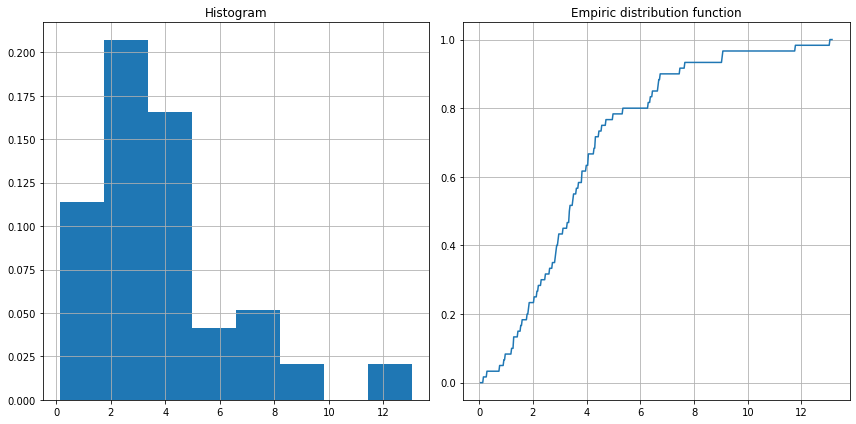

In [6]:
def emp_cdf(x: np.ndarray, sample: np.ndarray):
    f_arr = []
    size = len(sample)
    for i in x:
        freq = (len(sample[sample < i])) / size
        f_arr.append(freq)
    return np.array(f_arr)

def empiric_df(x: np.ndarray):
    return emp_cdf(x, numbers)

left = min(numbers)-0.1
right = max(numbers)+0.1
x = np.linspace(left, right, 500)

f, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(numbers, density=True, bins=8)
ax[0].grid()
ax[0].set_title('Histogram')

ax[1].plot(x, empiric_df(x))
ax[1].grid()
ax[1].set_title('Empiric distribution function')

f.tight_layout()

Доверительные полосы:

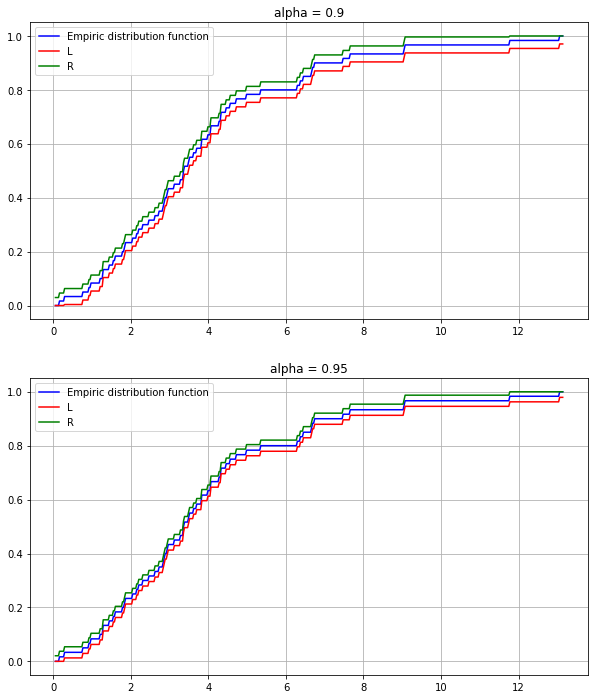

In [7]:
epsilon = lambda alpha: np.sqrt(np.log(1 / alpha) / 2 / len(numbers))
L = lambda alpha: np.array([max(F - epsilon(alpha), 0) for F in empiric_df(x)])
R = lambda alpha: np.array([min(F + epsilon(alpha), 1) for F in empiric_df(x)])

f, ax = plt.subplots(2, 1, figsize=(10, 12))

for i, alpha in zip(range(2), [0.9, 0.95]):
    ax[i].plot(x, empiric_df(x), color='b', label='Empiric distribution function')
    ax[i].plot(x, L(alpha), color='r', label='L')
    ax[i].plot(x, R(alpha), color='g', label='R')
    ax[i].grid()
    ax[i].set_title(f"alpha = {alpha}")
    ax[i].legend()

Проверка гипотезы на основе хи-квадрат Фишера:

In [8]:
from scipy.stats import lognorm
from typing import Union

def theoretic_df(x: Union[float, np.ndarray], sigma, mu):
    return lognorm.cdf(x, s=sigma, scale = np.exp(mu))

# s = sigma, scale = exp(mu)
# s = 0.72266845
# mean, var, skew, kurt = lognorm.stats(s, scale=np.exp(1.21071559), moments='mvsk')
# print(f"{mean}, {var}, {skew}, {kurt}")


In [9]:
def chi2_value(int_num: int, sigma: float, mu: float, nums, logging: bool = False):
    borders = np.linspace(left, right, int_num+1)
    N = len(nums)
    if logging:
        print(f"borders {borders}")
        print(N)
    res = 0
    for i in range(int_num):        
        p_k = theoretic_df(borders[i+1], sigma, mu) - theoretic_df(borders[i], sigma, mu)
        v_k = len([num for num in nums if borders[i] < num and num < borders[i+1]])
        if logging:
            print(f"curr borders: {borders[i], borders[i+1]}")
            print(f"v_k: {v_k}")
        res += (v_k - N*p_k)**2 / (N*p_k)
    
    return res
    

In [10]:
from scipy.optimize import minimize

orders = [7, 10, 15]
chi_4 = 9.4877
chi_7 = 14.0671
chi_12 = 21.0261

# print(chi2_value(10, 0.77231248, 1.26086924, nums=numbers))
theta = []

for chi, order in zip([chi_4, chi_7, chi_12], orders):
    chi2 = lambda x: chi2_value(order, sigma=x[0], mu=x[1], nums=numbers)
    result = minimize(chi2, np.array([1/5, 1.5]))
    print(f"Value: {result['fun']}, min: {result['x']}")
    theta.append(result['x'])
    print(result['fun'] < chi)

Value: 2.9286779826501403, min: [0.73984636 1.22578396]
True
Value: 6.154002281955785, min: [0.72266845 1.21071559]
True
Value: 15.37801796515877, min: [0.77231248 1.26086924]
True


[0.74494243 1.23245626]


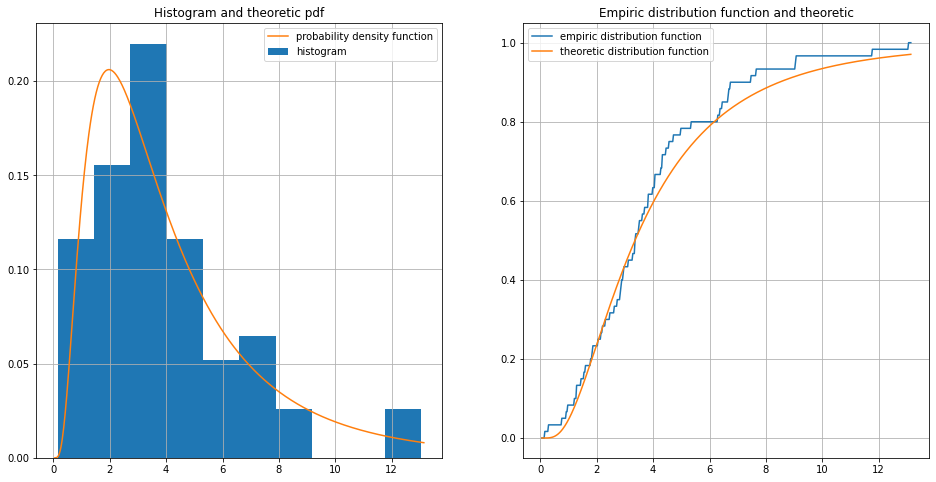

In [11]:
theta = np.array(theta)
mean_theta = np.mean(theta, axis=0)
print(mean_theta)

f, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].hist(numbers, density=True, label='histogram')
ax[0].plot(x, lognorm.pdf(x, s=mean_theta[0], scale= np.exp(mean_theta[1])), label='probability density function')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Histogram and theoretic pdf')

ax[1].plot(x, empiric_df(x), label='empiric distribution function')
ax[1].grid()
ax[1].set_title('Empiric distribution function and theoretic')
ax[1].plot(x, lognorm.cdf(x, s=0.72266845, scale= np.exp(1.21071559)), label='theoretic distribution function')
ax[1].legend()

In [12]:
mean, var, skew, kurt = lognorm.stats(mean_theta[0], scale=np.exp(mean_theta[1]), moments='mvsk')
print(f"{mean}, {var}, {skew}, {kurt}")

4.526395265628503, 15.19890635763621, 3.222836994188116, 22.876480587272262
